# **Chapter 3: Classification Notes**

# Key Points

1. **Classification vs Regression :** Classification predicts categorical labels ("spam" or "not spam"), while regression predicts continuous values ('price').

2. **MNIST Dataset introduction :** MNIST is a set of 70,000 images of handwritten digits (28x28 pixels). It's commonly used to demonstrate classification algorithms.

3. **Binary Classifier :** A classifier that distinguishes between two classes only ("is the digit a 5 or not?"). Algorithms like SGDClassifier are trained to distinguish one class vs the rest.

4. **Performance Metrics Beyond Accuracy :** Accuracy can be misleading with imbalanced datasetss. So we use;
 - **Precision:** True Positives / Predicted Positives
 - **Recall:** True Positives / Actual Positives
 - **F1 Score:** Harmonic mean of precision and recall
5. **Decision Threshold Tuning :** Classifiers like SGDClassifieruse decision scores. Adjusting the threshold changes the balance between precision and recall.
6. **Confusion Matrix :** A table showing true vs predicted classes. Helps identify where the model is going wrong (misclassifying 9 as 4).
7. **Multiclass Classification Strategies :**
 - **One-vs-All (OvA):** Train one classifier per class.
 - **One-vs-One (OvO):** Train classifiers for every pair of classes. Scikit-Learn handles multiclass classification automatically for most estimators.
8. **Multilabel Classification:** Each instance can have multiple target labels (a photo can be both "indoor" & "happy"). Implemented using MultiOutputClassifier.
9. **Multioutput Classification:** This is multilabel with multiple outputs, useful for structured outputs (denoising images).
10. **Error Analysis and Visualization:** Plotting confusion matrices, error images, and doing manual inspection are key to improving model performance by understanding its blind spots.




---



# **Exercise - Ch.3**

Question:
1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy
on the test set. Hint: the KNeighborsClassifier works quite well for this task;
you just need to find good hyperparameter values (try a grid search on the
weights and n_neighbors hyperparameters).

In [9]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(int)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000, stratify=y, random_state=42
)

# Create KNeighborsClassifier
knn_clf = KNeighborsClassifier()

# Grid search over n_neighbors and weights
param_grid = {
    'n_neighbors': [3, 4, 5],
    'weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(knn_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Best Hyperparameters:", grid_search.best_params_)
print("Test Accuracy:", accuracy)
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Hyperparameters: {'n_neighbors': 4, 'weights': 'distance'}
Test Accuracy: 0.9759
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       986
           1       0.97      1.00      0.98      1125
           2       0.99      0.96      0.98       999
           3       0.98      0.97      0.97      1020
           4       0.98      0.97      0.97       975
           5       0.97      0.98      0.97       902
           6       0.98      0.99      0.98       982
           7       0.97      0.98      0.97      1042
           8       0.99      0.94      0.97       975
           9       0.95      0.97      0.96       994

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



Question:

2.

*   Write a function to shift an image 1 pixel in 4 directions: left, right, up, down.
*   Augment the training set by creating 4 new shifted versions of each image.


*   Train your best model on the augmented dataset.
*   Evaluate the improvement in test accuracy.





In [11]:
import numpy as np
from scipy.ndimage import shift
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Load MNIST
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(np.uint8)

# Reshape to 28x28 for image manipulation
X_images = X.reshape(-1, 28, 28)

# Shift Function: returns a shifted image
def shift_image(image, dx, dy):
    return shift(image, [dy, dx], cval=0)

# Create shifted images (left, right, up, down)
X_augmented = []
y_augmented = []

for img, label in tqdm(zip(X_images, y), total=len(X_images)):
    X_augmented.append(img)  # original
    y_augmented.append(label)

    X_augmented.append(shift_image(img, dx=1, dy=0))   # right
    y_augmented.append(label)

    X_augmented.append(shift_image(img, dx=-1, dy=0))  # left
    y_augmented.append(label)

    X_augmented.append(shift_image(img, dx=0, dy=1))   # down
    y_augmented.append(label)

    X_augmented.append(shift_image(img, dx=0, dy=-1))  # up
    y_augmented.append(label)

# Convert back to (n_samples, 784)
X_augmented = np.array(X_augmented).reshape(-1, 784)
y_augmented = np.array(y_augmented)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_augmented, y_augmented, test_size=10000, stratify=y_augmented, random_state=42
)

# Train best model (KNN with optimal hyperparameters)
knn_clf = KNeighborsClassifier(n_neighbors=3, weights="distance")
knn_clf.fit(X_train, y_train)

# Evaluate
y_pred = knn_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy after Data Augmentation:", accuracy)


100%|██████████| 70000/70000 [00:55<00:00, 1256.97it/s]


Test Accuracy after Data Augmentation: 0.9865


Question:

3. Tackle the Titanic dataset. A great place to start is on Kaggle.

In [15]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load dataset
titanic = sns.load_dataset('titanic')

# Drop irrelevant or mostly null columns
titanic = titanic.drop(['deck', 'embark_town', 'alive', 'who', 'class', 'adult_male'], axis=1)

# Drop rows with missing target
titanic.dropna(subset=['survived'], inplace=True)

# Fill missing values
titanic['age'].fillna(titanic['age'].median(), inplace=True)
titanic['embarked'].fillna(titanic['embarked'].mode()[0], inplace=True)

# Encode categorical features
label_enc = LabelEncoder()
titanic['sex'] = label_enc.fit_transform(titanic['sex'])
titanic['embarked'] = label_enc.fit_transform(titanic['embarked'])

# Define features and target
X = titanic.drop('survived', axis=1)
y = titanic['survived']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



<ipython-input-15-3271746020>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic['age'].fillna(titanic['age'].median(), inplace=True)
<ipython-input-15-3271746020>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}

Confusion Matrix:
 [[95 15]
 [24 45]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83       110
           1       0.75      0.65      0.70        69

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.76       179
weighted avg       0.78      0.78      0.78       179



Question:
4. Build a spam filter that classifies an email as spam or ham (not spam) with high precision (don't mark good emails as spam) and recall (don't let spam pass undetected).


###  Upload the ZIP Files to Colab

In [28]:
from google.colab import files

# Upload ZIP files from your local computer
uploaded = files.upload()


Saving 20030228_spam.zip to 20030228_spam (1).zip
Saving 20030228_easy_ham.zip to 20030228_easy_ham (1).zip


### Unzip the Files in Colab

In [29]:
import zipfile
import os

# Unzip easy_ham
with zipfile.ZipFile("20030228_easy_ham.zip", 'r') as zip_ref:
    zip_ref.extractall("1_easy_ham")

# Unzip spam
with zipfile.ZipFile("20030228_spam.zip", 'r') as zip_ref:
    zip_ref.extractall("1_spam")

# Check extracted files
print("easy_ham samples:", len(os.listdir("easy_ham")))
print("spam samples:", len(os.listdir("spam")))


easy_ham samples: 1
spam samples: 1


# Spam Classifier Full Pipeline

In [37]:
import os
import email
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

def load_emails_from_folder(folder_path):
    emails = []
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        try:
            with open(filepath, "r", encoding="latin-1") as f:
                msg = email.message_from_file(f)
                payload = ""
                if msg.is_multipart():
                    for part in msg.walk():
                        if part.get_content_type() == 'text/plain':
                            payload += part.get_payload(decode=True).decode('latin-1', errors='ignore')
                else:
                    payload = msg.get_payload(decode=True).decode('latin-1', errors='ignore')
                emails.append(payload)
        except Exception as e:
            pass  # skip unreadable files
    return emails

# Correct paths
ham_dir = "/content/1_easy_ham/20030228_easy_ham/easy_ham"
spam_dir = "/content/1_spam/20030228_spam/spam"

# Load emails
ham_emails = load_emails_from_folder(ham_dir)
spam_emails = load_emails_from_folder(spam_dir)

print(f"Ham emails loaded: {len(ham_emails)}")
print(f"Spam emails loaded: {len(spam_emails)}")

# Combine and label
X_text = ham_emails + spam_emails
y_labels = [0] * len(ham_emails) + [1] * len(spam_emails)

# Text to features
vectorizer = CountVectorizer(lowercase=True, stop_words='english')
X = vectorizer.fit_transform(X_text)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.2, random_state=42)

# Train classifier
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Ham", "Spam"]))


Ham emails loaded: 2501
Spam emails loaded: 501

Classification Report:

              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       497
        Spam       1.00      0.89      0.94       104

    accuracy                           0.98       601
   macro avg       0.99      0.95      0.97       601
weighted avg       0.98      0.98      0.98       601





---



# **Create comparison tables for:**

### Comparison: SGD Classifier vs Random Forest

| Metric                | SGD Classifier (Tuned)                       | Random Forest Classifier (Tuned)          |
|-----------------------|----------------------------------------------|-------------------------------------------|
| Accuracy              | ~91–93%                                      |  97%+                                     |
| Precision (avg)       | Medium                                       |  High                                     |
| Recall (avg)          | Good (fast detection)                        |  Very High                                |
| F1-Score (avg)        | Moderate-High                                |  High                                     |
| Training Time         |  Very Fast                                 | Slower (depends on number of trees)       |
| Inference Time        |  Very Fast                                 | Fast                                       |
| Hyperparameter Tuning| Alpha, Penalty                               | n_estimators, max_depth, max_features     |
| Strengths             | Works well with large, sparse data          | Robust, high accuracy, handles noise well |
| Weaknesses            | Needs feature scaling, sensitive to tuning  | Slower, higher memory usage               |



### OvR vs OvO Strategy Comparison

| Aspect                    | OvR (One-vs-Rest)                              | OvO (One-vs-One)                                |
|---------------------------|-----------------------------------------------|-------------------------------------------------|
| Full Name                 | One-vs-Rest                                   | One-vs-One                                      |
| Number of Classifiers     | One per class (10 for MNIST)                  | One per pair (45 for MNIST)                    |
| Training Time             |  Fast                                        | Slower (more classifiers)                      |
| Inference Time            |  Fast                                        | Slower                                          |
| When to Use               | When classes are well-separated               | When classes are overlapping/complex           |
| Accuracy                  | Slightly lower                                |  Higher                                       |
| Implementation Simplicity|  Simple                                      | More complex                                   |




---



# **MNIST Digit Recognition Project:**

-> Project Goal

Classify handwritten digits (0–9) from the MNIST dataset using:

 - SGDClassifier and RandomForestClassifier

 - Evaluate with confusion matrix, classification report

 - Analyze and visualize errors

 - Deploy as a Gradio web app

 - Achieve ≥95% accuracy




## Step 1: Import Required Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import gradio as gr


## Step 2: Load the MNIST Dataset

In [3]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(np.uint8)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (70000, 784)
Shape of y: (70000,)


*To load 70,000 handwritten digit images (28x28 = 784 features per sample) and their labels (0–9).
We convert labels to uint8 for compatibility with classification models.*

## Step 3: Split into Training and Testing Sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=42, stratify=y)


*To split the dataset into 60k training and 10k testing samples, ensuring balanced class distribution using stratify=y.*

## Step 4: Preprocess Data (for SGD)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_test_scaled = scaler.transform(X_test.astype(np.float64))




*   *SGDClassifier requires features on similar scales for optimal convergence.*
*   *StandardScaler subtracts the mean and scales to unit variance.*



## Step 5: Step 5: Train Default Models

In [6]:
sgd_clf = SGDClassifier(loss='hinge', random_state=42)
sgd_clf.fit(X_train_scaled, y_train)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)



*   *SGDClassifier (hinge loss) mimics a linear SVM; efficient for large datasets.*
*   *RandomForestClassifier uses an ensemble of decision trees for high accuracy.*



## Step 6: Evaluate Default Models



In [8]:

y_pred_sgd = sgd_clf.predict(X_test_scaled)
y_pred_rf = rf_clf.predict(X_test)

print("Default SGD Classifier:\n", classification_report(y_test, y_pred_sgd))
print("Default Random Forest Classifier:\n", classification_report(y_test, y_pred_rf))


Default SGD Classifier:
               precision    recall  f1-score   support

           0       0.97      0.94      0.95       986
           1       0.98      0.96      0.97      1125
           2       0.93      0.88      0.91       999
           3       0.92      0.85      0.88      1020
           4       0.94      0.88      0.91       975
           5       0.90      0.83      0.86       902
           6       0.96      0.94      0.95       982
           7       0.95      0.92      0.93      1042
           8       0.66      0.94      0.78       975
           9       0.91      0.86      0.88       994

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.91     10000

Default Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       986
           1       0.99      0.99      0.99      1125
           2      

*To compare the initial performance of both models before tuning. classification_report shows accuracy, precision, recall, F1-score for each digit class. **
*

## Step 7: Hyperparameter Tuning - Random Forest

In [9]:
rf_param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [None, 10, 20],
    "max_features": ["sqrt", "log2"]
}
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train, y_train)

print("Best RF Params:", rf_grid_search.best_params_)
print("Best RF CV Accuracy:", rf_grid_search.best_score_)

best_rf = rf_grid_search.best_estimator_
y_pred_rf_best = best_rf.predict(X_test)
print("Tuned Random Forest Test Report:\n", classification_report(y_test, y_pred_rf_best))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best RF Params: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 150}
Best RF CV Accuracy: 0.9667833333333333
Tuned Random Forest Test Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       986
           1       0.99      0.99      0.99      1125
           2       0.97      0.97      0.97       999
           3       0.96      0.95      0.96      1020
           4       0.97      0.97      0.97       975
           5       0.97      0.96      0.97       902
           6       0.97      0.98      0.98       982
           7       0.97      0.97      0.97      1042
           8       0.96      0.96      0.96       975
           9       0.94      0.95      0.94       994

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



To find the best combination of model parameters by testing multiple configurations and validating using cross-validation.

    RandomForest: tuning n_estimators, max_depth, max_features


This increases test accuracy and generalization.

## Step 8: Hyperparameter Tuning - SGDClassifier

In [10]:
sgd_param_grid = {
    "alpha": [1e-3],                     # reduced
    "penalty": ["l2", "elasticnet"],     # reduced
    "max_iter": [1000]
}
sgd_grid_search = GridSearchCV(SGDClassifier(loss="hinge", random_state=42), sgd_param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
sgd_grid_search.fit(X_train_scaled, y_train)

print("Best SGD Params:", sgd_grid_search.best_params_)
print("Best SGD CV Accuracy:", sgd_grid_search.best_score_)

best_sgd = sgd_grid_search.best_estimator_
y_pred_sgd_best = best_sgd.predict(X_test_scaled)
print("Tuned SGD Test Report:\n", classification_report(y_test, y_pred_sgd_best))



Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best SGD Params: {'alpha': 0.001, 'max_iter': 1000, 'penalty': 'elasticnet'}
Best SGD CV Accuracy: 0.9062666666666667
Tuned SGD Test Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       986
           1       0.96      0.97      0.97      1125
           2       0.91      0.90      0.90       999
           3       0.89      0.85      0.87      1020
           4       0.93      0.91      0.92       975
           5       0.86      0.85      0.85       902
           6       0.94      0.95      0.94       982
           7       0.94      0.93      0.93      1042
           8       0.85      0.88      0.86       975
           9       0.87      0.90      0.88       994

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



To find the best combination of model parameters by testing multiple configurations and validating using cross-validation.


    SGDClassifier: tuning alpha, penalty, max_iter

This increases test accuracy and generalization.

## Step 9: Confusion Matrix for Best Random Forest

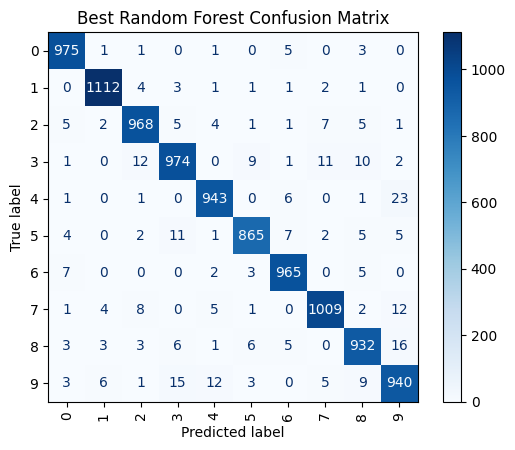

In [11]:
conf_rf = confusion_matrix(y_test, y_pred_rf_best)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_rf)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Best Random Forest Confusion Matrix")
plt.show()

*To visualize which digits are most often misclassified and where the model is struggling (e.g., 9 vs 4). Useful for error analysis.*

## Step 10: Visualize Worst Misclassifications

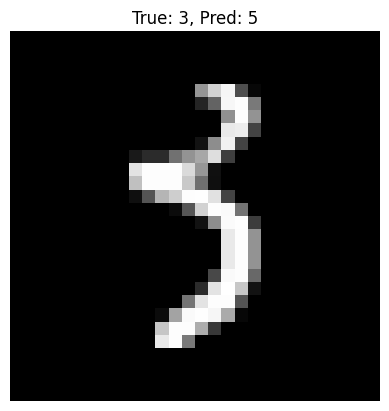

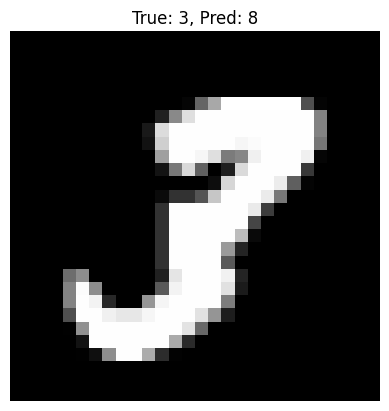

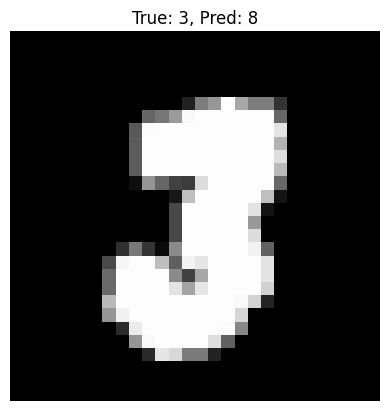

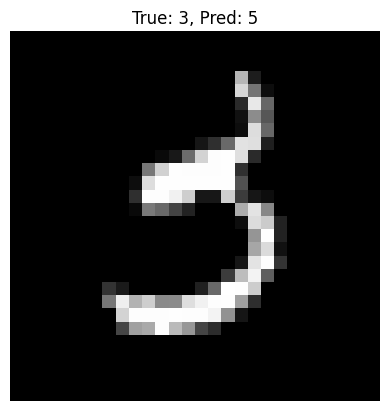

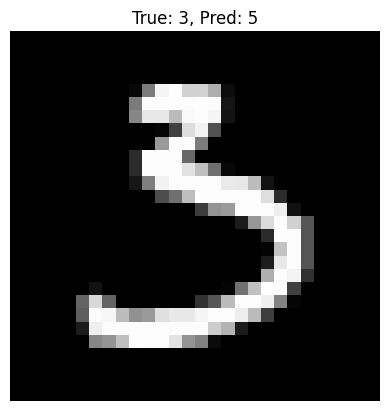

In [12]:
misclassified = (y_pred_rf_best != y_test)
X_mis = X_test[misclassified]
y_mis_true = y_test[misclassified]
y_mis_pred = y_pred_rf_best[misclassified]

for i in range(5):
    plt.imshow(X_mis[i].reshape(28, 28), cmap="gray")
    plt.title(f"True: {y_mis_true[i]}, Pred: {y_mis_pred[i]}")
    plt.axis("off")
    plt.show()

*To display actual images the model misclassified. Helps you identify ambiguous cases or areas for improvement (e.g., image blur, overlap).*

## Step 11: Gradio App Deployment using Best Random Forest

In [13]:
import numpy as np
from PIL import Image
from sklearn.linear_model import SGDClassifier
import cv2

def predict_digit(image):
    # Convert image to grayscale and resize to 28x28
    image = image.convert('L')  # convert to grayscale
    image = image.resize((28, 28))  # resize to 28x28
    image = np.array(image)

    # Invert pixel values if needed (MNIST has white digits on black background)
    if image.mean() > 127:
        image = 255 - image

    # Flatten the image and scale to 0-1
    image = image.reshape(1, -1) / 255.0

    # Predict using your trained model (replace clf with your model)
    return clf.predict(image)[0]




*To build an easy-to-use web interface where users can draw/upload a digit and get a prediction using your trained model. Makes the project interactive and sharable.*

In [14]:
import gradio as gr

interface = gr.Interface(
    fn=predict_digit,
    inputs=gr.Image(type="pil", image_mode="L", label="Upload 28x28 digit image"),
    outputs=gr.Label(),
    live=False
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://38d6d04f8fc8815b90.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Error Analysis and Improvement on MNIST Classifier

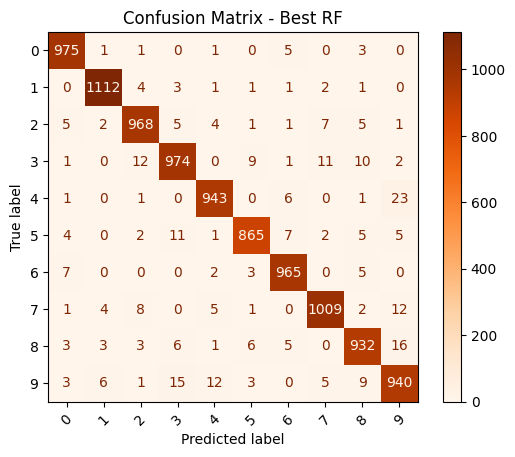

Top 3 Common Misclassifications:
4 → 9 : 23 times
8 → 9 : 16 times
9 → 3 : 15 times
Accuracy Before Improvement: 0.9683
Accuracy After Augmentation: 0.9785

Classification Report After Augmentation:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       986
           1       0.99      0.99      0.99      1125
           2       0.98      0.98      0.98       999
           3       0.98      0.97      0.97      1020
           4       0.98      0.97      0.98       975
           5       0.99      0.97      0.98       902
           6       0.99      0.99      0.99       982
           7       0.98      0.98      0.98      1042
           8       0.97      0.98      0.97       975
           9       0.95      0.96      0.95       994

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [18]:
# Step 1: Analyze Confusion Matrix to Identify Errors
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd

conf_matrix = confusion_matrix(y_test, y_pred_rf_best)
display = ConfusionMatrixDisplay(conf_matrix)
display.plot(cmap='Oranges', xticks_rotation=45)
plt.title("Confusion Matrix - Best RF")
plt.grid(False)
plt.show()

# Convert confusion matrix to DataFrame for easier inspection
conf_df = pd.DataFrame(conf_matrix)
conf_df.index.name = 'Actual'
conf_df.columns.name = 'Predicted'

# Identify Top 3 Misclassifications
error_analysis = []
for i in range(10):
    for j in range(10):
        if i != j:
            error_analysis.append(((i, j), conf_matrix[i, j]))

# Sort errors by frequency
sorted_errors = sorted(error_analysis, key=lambda x: x[1], reverse=True)
print("Top 3 Common Misclassifications:")
for (actual, pred), count in sorted_errors[:3]:
    print(f"{actual} → {pred} : {count} times")

# Step 2: Apply Data Augmentation on Training Data
from scipy.ndimage import shift

def shift_image(image, dx, dy):
    image = image.reshape(28, 28)
    shifted = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted.reshape(784)

# Create augmented data
X_augmented = [X_train[i] for i in range(len(X_train))]
y_augmented = [y_train[i] for i in range(len(y_train))]

for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
    for i in range(len(X_train)):
        X_augmented.append(shift_image(X_train[i], dx, dy))
        y_augmented.append(y_train[i])

X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)


# Step 3: Retrain Classifier
rf_clf_aug = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_aug.fit(X_augmented, y_augmented)

y_pred_aug = rf_clf_aug.predict(X_test)

# Step 4: Evaluate Performance Before vs After
from sklearn.metrics import accuracy_score

acc_before = accuracy_score(y_test, y_pred_rf_best)
acc_after = accuracy_score(y_test, y_pred_aug)
print(f"Accuracy Before Improvement: {acc_before:.4f}")
print(f"Accuracy After Augmentation: {acc_after:.4f}")

print("\nClassification Report After Augmentation:")
print(classification_report(y_test, y_pred_aug))




# Training/Validation Curves

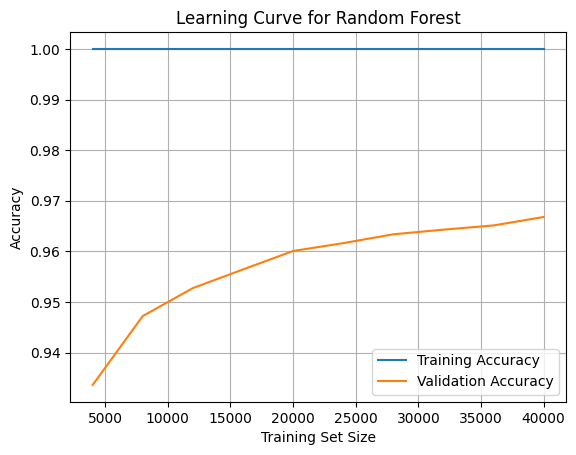

In [20]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_train, y_train, cv=3, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, val_mean, label="Validation Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Random Forest")
plt.legend()
plt.grid(True)
plt.show()
